In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='3'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='max_temp'
SAMPLE_SIZE=5000

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV1,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV1,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1-jsons')
ORIGINAL_PROFILE_LIST_JSON = '/workspace/outputs/profiles-v1/profiles_v1_experiment_2_20250326_0344/profile_list_v1_in_range.json'
LABEL = f'profiles_v1_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v1', 'profile_list_v1_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v1_experiment_3_20250330_1413


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v1_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 137437/137437 [01:11<00:00, 1919.62it/s]

Saved 137437 profiles to /workspace/outputs/profiles_v1_experiment_3_20250330_1413/20250330-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV1(csv_path, DEVICE)

Loading Profiles: 137437it [00:05, 25485.14it/s]


Saved figure to /workspace/outputs/profiles_v1_experiment_3_20250330_1413/density_plot.png


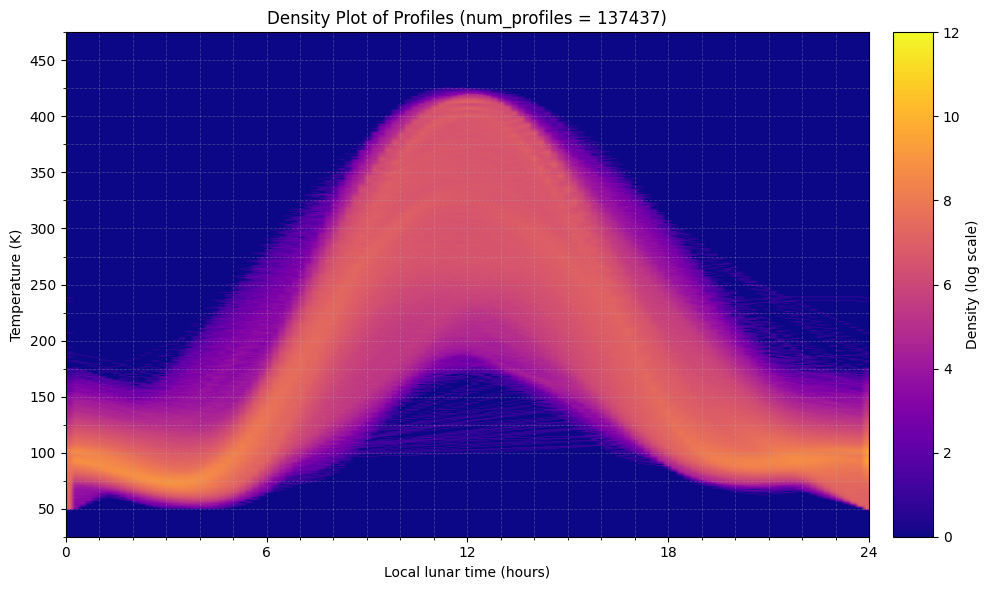

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v1_experiment_3_20250330_1413/histogram_max_temp.png


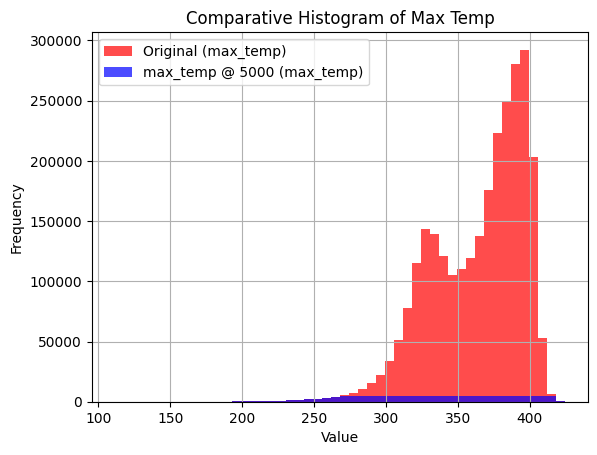

Saved figure to /workspace/outputs/profiles_v1_experiment_3_20250330_1413/histogram_min_temp.png


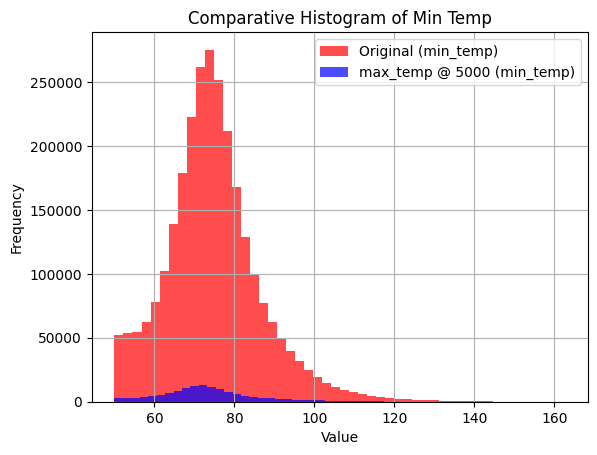

Saved figure to /workspace/outputs/profiles_v1_experiment_3_20250330_1413/histogram_mean_temp.png


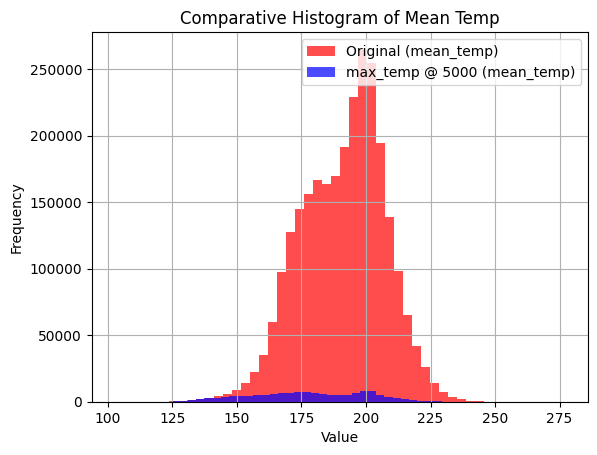

Saved figure to /workspace/outputs/profiles_v1_experiment_3_20250330_1413/histogram_std_temp.png


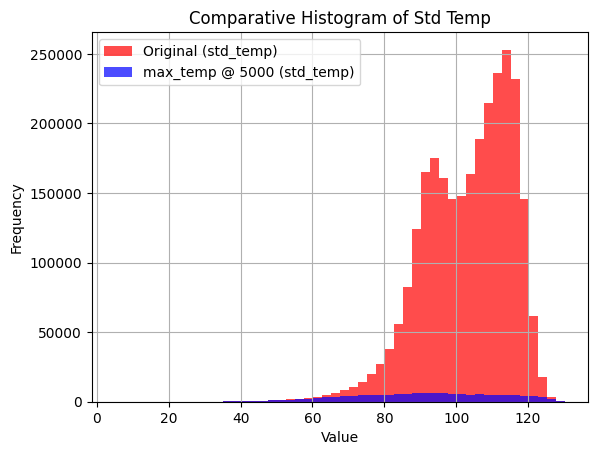

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV1(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV1(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 177.5949
STD: 95.9303
Min Temp: 50.0010
Max Temp: 424.9460
Datasets:
Training Data: 96205
Validation Data: 27487
Test Data: 13745


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 482/482 [00:14<00:00, 32.60it/s, best_loss=0.7103]


[Training] Epoch 1/100, L1 Loss: 0.7866, L2 Loss: 0.9994, KL Loss: 0.0032, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 138/138 [00:01<00:00, 112.44it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_3_20250330_1413'


[Training] Epoch 2/100: 100%|██████████| 482/482 [00:14<00:00, 32.25it/s, best_loss=0.8451]


[Training] Epoch 2/100, L1 Loss: 0.7870, L2 Loss: 1.0003, KL Loss: 0.0002, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 138/138 [00:01<00:00, 113.69it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0002


[Training] Epoch 3/100: 100%|██████████| 482/482 [00:15<00:00, 31.80it/s, best_loss=0.8122]


[Training] Epoch 3/100, L1 Loss: 0.7866, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 138/138 [00:01<00:00, 113.45it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 4/100: 100%|██████████| 482/482 [00:15<00:00, 31.71it/s, best_loss=0.8038]


[Training] Epoch 4/100, L1 Loss: 0.7865, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 138/138 [00:01<00:00, 113.77it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 5/100: 100%|██████████| 482/482 [00:14<00:00, 32.23it/s, best_loss=0.8001]


[Training] Epoch 5/100, L1 Loss: 0.7866, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 138/138 [00:01<00:00, 114.59it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 6/100: 100%|██████████| 482/482 [00:15<00:00, 31.80it/s, best_loss=0.8312]


[Training] Epoch 6/100, L1 Loss: 0.7873, L2 Loss: 1.0023, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 138/138 [00:01<00:00, 115.26it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 7/100: 100%|██████████| 482/482 [00:15<00:00, 31.99it/s, best_loss=0.8286]


[Training] Epoch 7/100, L1 Loss: 0.7867, L2 Loss: 0.9996, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 138/138 [00:01<00:00, 112.43it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 8/100: 100%|██████████| 482/482 [00:16<00:00, 30.11it/s, best_loss=0.8424]


[Training] Epoch 8/100, L1 Loss: 0.7874, L2 Loss: 1.0022, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 138/138 [00:01<00:00, 112.22it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 9/100: 100%|██████████| 482/482 [00:15<00:00, 31.65it/s, best_loss=0.8110]


[Training] Epoch 9/100, L1 Loss: 0.7869, L2 Loss: 1.0002, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 138/138 [00:01<00:00, 110.15it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0002


[Training] Epoch 10/100: 100%|██████████| 482/482 [00:15<00:00, 30.74it/s, best_loss=0.8195]


[Training] Epoch 10/100, L1 Loss: 0.7866, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 138/138 [00:01<00:00, 111.16it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 11/100: 100%|██████████| 482/482 [00:15<00:00, 32.12it/s, best_loss=0.8425]


[Training] Epoch 11/100, L1 Loss: 0.7873, L2 Loss: 1.0011, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 138/138 [00:01<00:00, 114.09it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 12/100: 100%|██████████| 482/482 [00:15<00:00, 31.22it/s, best_loss=0.8298]


[Training] Epoch 12/100, L1 Loss: 0.7869, L2 Loss: 1.0007, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 138/138 [00:01<00:00, 111.75it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 13/100: 100%|██████████| 482/482 [00:15<00:00, 31.58it/s, best_loss=0.8446]


[Training] Epoch 13/100, L1 Loss: 0.7866, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 138/138 [00:01<00:00, 111.18it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 14/100: 100%|██████████| 482/482 [00:15<00:00, 31.47it/s, best_loss=0.5869]


[Training] Epoch 14/100, L1 Loss: 0.7864, L2 Loss: 0.9992, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 138/138 [00:01<00:00, 111.03it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 15/100: 100%|██████████| 482/482 [00:14<00:00, 32.27it/s, best_loss=0.8069]


[Training] Epoch 15/100, L1 Loss: 0.7868, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 138/138 [00:01<00:00, 113.07it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 16/100: 100%|██████████| 482/482 [00:15<00:00, 31.81it/s, best_loss=0.8475]


[Training] Epoch 16/100, L1 Loss: 0.7867, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 138/138 [00:01<00:00, 96.66it/s] 


[Validation] Epoch 16/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 17/100: 100%|██████████| 482/482 [00:14<00:00, 32.33it/s, best_loss=0.7831]


[Training] Epoch 17/100, L1 Loss: 0.7866, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 138/138 [00:01<00:00, 120.70it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 18/100: 100%|██████████| 482/482 [00:15<00:00, 31.66it/s, best_loss=0.8160]


[Training] Epoch 18/100, L1 Loss: 0.7870, L2 Loss: 1.0006, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 138/138 [00:01<00:00, 91.80it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 19/100: 100%|██████████| 482/482 [00:15<00:00, 31.51it/s, best_loss=0.8163]


[Training] Epoch 19/100, L1 Loss: 0.7869, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 138/138 [00:01<00:00, 106.82it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 20/100: 100%|██████████| 482/482 [00:14<00:00, 32.21it/s, best_loss=0.7973]


[Training] Epoch 20/100, L1 Loss: 0.7867, L2 Loss: 0.9999, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 138/138 [00:01<00:00, 101.36it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 21/100: 100%|██████████| 482/482 [00:15<00:00, 31.77it/s, best_loss=0.5225]


[Training] Epoch 21/100, L1 Loss: 0.7863, L2 Loss: 0.9990, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 138/138 [00:01<00:00, 116.10it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 22/100: 100%|██████████| 482/482 [00:15<00:00, 31.40it/s, best_loss=0.8266]


[Training] Epoch 22/100, L1 Loss: 0.7871, L2 Loss: 1.0007, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 138/138 [00:01<00:00, 109.05it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 23/100: 100%|██████████| 482/482 [00:15<00:00, 31.68it/s, best_loss=0.8312]


[Training] Epoch 23/100, L1 Loss: 0.7869, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 138/138 [00:01<00:00, 117.51it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 24/100: 100%|██████████| 482/482 [00:15<00:00, 31.63it/s, best_loss=0.8063]


[Training] Epoch 24/100, L1 Loss: 0.7869, L2 Loss: 1.0006, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 138/138 [00:01<00:00, 111.80it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 25/100: 100%|██████████| 482/482 [00:15<00:00, 31.58it/s, best_loss=0.8340]


[Training] Epoch 25/100, L1 Loss: 0.7872, L2 Loss: 1.0015, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 138/138 [00:01<00:00, 106.60it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 26/100: 100%|██████████| 482/482 [00:14<00:00, 33.19it/s, best_loss=0.8214]


[Training] Epoch 26/100, L1 Loss: 0.7872, L2 Loss: 1.0006, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 138/138 [00:01<00:00, 114.49it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 27/100: 100%|██████████| 482/482 [00:15<00:00, 31.82it/s, best_loss=0.8315]


[Training] Epoch 27/100, L1 Loss: 0.7870, L2 Loss: 1.0004, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 138/138 [00:01<00:00, 117.61it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 28/100: 100%|██████████| 482/482 [00:14<00:00, 32.42it/s, best_loss=0.8218]


[Training] Epoch 28/100, L1 Loss: 0.7868, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 138/138 [00:01<00:00, 116.51it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 29/100: 100%|██████████| 482/482 [00:15<00:00, 31.51it/s, best_loss=0.8416]


[Training] Epoch 29/100, L1 Loss: 0.7873, L2 Loss: 1.0017, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 138/138 [00:01<00:00, 113.87it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 30/100: 100%|██████████| 482/482 [00:15<00:00, 31.68it/s, best_loss=0.8127]


[Training] Epoch 30/100, L1 Loss: 0.7869, L2 Loss: 1.0004, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 138/138 [00:01<00:00, 112.99it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 31/100: 100%|██████████| 482/482 [00:15<00:00, 31.29it/s, best_loss=0.7965]


[Training] Epoch 31/100, L1 Loss: 0.7867, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 138/138 [00:01<00:00, 112.03it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 32/100: 100%|██████████| 482/482 [00:15<00:00, 31.90it/s, best_loss=0.6829]


[Training] Epoch 32/100, L1 Loss: 0.7865, L2 Loss: 0.9993, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 138/138 [00:01<00:00, 119.01it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0002


[Training] Epoch 33/100: 100%|██████████| 482/482 [00:15<00:00, 31.32it/s, best_loss=0.8223]


[Training] Epoch 33/100, L1 Loss: 0.7867, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 138/138 [00:01<00:00, 112.69it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 34/100: 100%|██████████| 482/482 [00:15<00:00, 31.71it/s, best_loss=0.8196]


[Training] Epoch 34/100, L1 Loss: 0.7867, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 138/138 [00:01<00:00, 112.35it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 35/100: 100%|██████████| 482/482 [00:15<00:00, 31.95it/s, best_loss=0.8105]


[Training] Epoch 35/100, L1 Loss: 0.7871, L2 Loss: 1.0008, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 138/138 [00:01<00:00, 87.37it/s] 


[Validation] Epoch 35/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 36/100: 100%|██████████| 482/482 [00:15<00:00, 31.61it/s, best_loss=0.8298]


[Training] Epoch 36/100, L1 Loss: 0.7872, L2 Loss: 1.0014, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 138/138 [00:01<00:00, 117.79it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 37/100: 100%|██████████| 482/482 [00:15<00:00, 31.45it/s, best_loss=0.8368]


[Training] Epoch 37/100, L1 Loss: 0.7868, L2 Loss: 1.0005, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 138/138 [00:01<00:00, 102.03it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0002


[Training] Epoch 38/100: 100%|██████████| 482/482 [00:15<00:00, 32.13it/s, best_loss=0.6397]


[Training] Epoch 38/100, L1 Loss: 0.7864, L2 Loss: 0.9993, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 138/138 [00:01<00:00, 120.97it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0002


[Training] Epoch 39/100: 100%|██████████| 482/482 [00:15<00:00, 32.11it/s, best_loss=0.8034]


[Training] Epoch 39/100, L1 Loss: 0.7867, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 138/138 [00:01<00:00, 110.80it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 40/100: 100%|██████████| 482/482 [00:15<00:00, 31.29it/s, best_loss=0.4277]


[Training] Epoch 40/100, L1 Loss: 0.7861, L2 Loss: 0.9988, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 138/138 [00:01<00:00, 111.73it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 41/100: 100%|██████████| 482/482 [00:15<00:00, 31.90it/s, best_loss=0.8073]


[Training] Epoch 41/100, L1 Loss: 0.7869, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 138/138 [00:01<00:00, 120.24it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 42/100: 100%|██████████| 482/482 [00:15<00:00, 31.41it/s, best_loss=0.8262]


[Training] Epoch 42/100, L1 Loss: 0.7867, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 138/138 [00:01<00:00, 112.21it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 43/100: 100%|██████████| 482/482 [00:15<00:00, 31.42it/s, best_loss=0.8226]


[Training] Epoch 43/100, L1 Loss: 0.7867, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 138/138 [00:01<00:00, 112.95it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 44/100: 100%|██████████| 482/482 [00:15<00:00, 31.36it/s, best_loss=0.8086]


[Training] Epoch 44/100, L1 Loss: 0.7868, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 138/138 [00:01<00:00, 107.86it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 45/100: 100%|██████████| 482/482 [00:15<00:00, 31.79it/s, best_loss=0.8100]


[Training] Epoch 45/100, L1 Loss: 0.7866, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 138/138 [00:01<00:00, 107.91it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 46/100: 100%|██████████| 482/482 [00:15<00:00, 31.05it/s, best_loss=0.7812]


[Training] Epoch 46/100, L1 Loss: 0.7866, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 138/138 [00:01<00:00, 115.62it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 47/100: 100%|██████████| 482/482 [00:15<00:00, 31.81it/s, best_loss=0.8103]


[Training] Epoch 47/100, L1 Loss: 0.7868, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 138/138 [00:01<00:00, 109.73it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 48/100: 100%|██████████| 482/482 [00:15<00:00, 30.69it/s, best_loss=0.8142]


[Training] Epoch 48/100, L1 Loss: 0.7867, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 138/138 [00:01<00:00, 110.33it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 49/100: 100%|██████████| 482/482 [00:14<00:00, 32.44it/s, best_loss=0.8417]


[Training] Epoch 49/100, L1 Loss: 0.7868, L2 Loss: 1.0007, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 138/138 [00:01<00:00, 125.97it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 50/100: 100%|██████████| 482/482 [00:15<00:00, 31.34it/s, best_loss=0.3941]


[Training] Epoch 50/100, L1 Loss: 0.7862, L2 Loss: 0.9988, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 138/138 [00:01<00:00, 112.48it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 51/100: 100%|██████████| 482/482 [00:14<00:00, 32.19it/s, best_loss=0.8290]


[Training] Epoch 51/100, L1 Loss: 0.7874, L2 Loss: 1.0013, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 138/138 [00:01<00:00, 109.48it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 52/100: 100%|██████████| 482/482 [00:15<00:00, 31.40it/s, best_loss=0.7670]


[Training] Epoch 52/100, L1 Loss: 0.7866, L2 Loss: 0.9995, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 138/138 [00:01<00:00, 115.73it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 53/100: 100%|██████████| 482/482 [00:14<00:00, 32.48it/s, best_loss=0.5013]


[Training] Epoch 53/100, L1 Loss: 0.7863, L2 Loss: 0.9990, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 138/138 [00:01<00:00, 113.95it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0002


[Training] Epoch 54/100: 100%|██████████| 482/482 [00:15<00:00, 31.86it/s, best_loss=0.7329]


[Training] Epoch 54/100, L1 Loss: 0.7866, L2 Loss: 0.9995, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 138/138 [00:01<00:00, 102.85it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 55/100: 100%|██████████| 482/482 [00:14<00:00, 32.94it/s, best_loss=0.7863]


[Training] Epoch 55/100, L1 Loss: 0.7869, L2 Loss: 1.0008, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 138/138 [00:01<00:00, 121.81it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 56/100: 100%|██████████| 482/482 [00:15<00:00, 31.81it/s, best_loss=0.6506]


[Training] Epoch 56/100, L1 Loss: 0.7865, L2 Loss: 0.9993, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 138/138 [00:01<00:00, 104.34it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 57/100: 100%|██████████| 482/482 [00:15<00:00, 31.98it/s, best_loss=0.7115]


[Training] Epoch 57/100, L1 Loss: 0.7865, L2 Loss: 0.9994, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 138/138 [00:01<00:00, 105.72it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0002


[Training] Epoch 58/100: 100%|██████████| 482/482 [00:15<00:00, 31.46it/s, best_loss=0.7775]


[Training] Epoch 58/100, L1 Loss: 0.7866, L2 Loss: 0.9995, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 138/138 [00:01<00:00, 108.40it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 59/100: 100%|██████████| 482/482 [00:15<00:00, 31.75it/s, best_loss=0.8411]


[Training] Epoch 59/100, L1 Loss: 0.7871, L2 Loss: 1.0008, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 138/138 [00:01<00:00, 100.16it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 60/100: 100%|██████████| 482/482 [00:15<00:00, 31.84it/s, best_loss=0.8067]


[Training] Epoch 60/100, L1 Loss: 0.7867, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 138/138 [00:01<00:00, 114.82it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 61/100: 100%|██████████| 482/482 [00:15<00:00, 31.38it/s, best_loss=0.8086]


[Training] Epoch 61/100, L1 Loss: 0.7865, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 138/138 [00:01<00:00, 113.00it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 62/100: 100%|██████████| 482/482 [00:15<00:00, 31.90it/s, best_loss=0.8487]


[Training] Epoch 62/100, L1 Loss: 0.7869, L2 Loss: 1.0000, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 138/138 [00:01<00:00, 111.76it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 63/100: 100%|██████████| 482/482 [00:15<00:00, 30.85it/s, best_loss=0.8010]


[Training] Epoch 63/100, L1 Loss: 0.7868, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 138/138 [00:01<00:00, 110.67it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 64/100: 100%|██████████| 482/482 [00:14<00:00, 32.23it/s, best_loss=0.4627]


[Training] Epoch 64/100, L1 Loss: 0.7863, L2 Loss: 0.9989, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 138/138 [00:01<00:00, 115.56it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0002


[Training] Epoch 65/100: 100%|██████████| 482/482 [00:15<00:00, 31.46it/s, best_loss=0.7838]


[Training] Epoch 65/100, L1 Loss: 0.7865, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 138/138 [00:01<00:00, 116.45it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 66/100: 100%|██████████| 482/482 [00:15<00:00, 32.00it/s, best_loss=0.8180]


[Training] Epoch 66/100, L1 Loss: 0.7871, L2 Loss: 1.0004, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 138/138 [00:01<00:00, 104.86it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 67/100: 100%|██████████| 482/482 [00:15<00:00, 31.86it/s, best_loss=0.7892]


[Training] Epoch 67/100, L1 Loss: 0.7873, L2 Loss: 1.0015, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 138/138 [00:01<00:00, 119.13it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 68/100: 100%|██████████| 482/482 [00:14<00:00, 32.30it/s, best_loss=0.7058]


[Training] Epoch 68/100, L1 Loss: 0.7867, L2 Loss: 0.9994, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 138/138 [00:01<00:00, 109.07it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 69/100: 100%|██████████| 482/482 [00:15<00:00, 32.03it/s, best_loss=0.7995]


[Training] Epoch 69/100, L1 Loss: 0.7874, L2 Loss: 1.0013, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 138/138 [00:01<00:00, 123.87it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 70/100: 100%|██████████| 482/482 [00:15<00:00, 32.04it/s, best_loss=0.5702]


[Training] Epoch 70/100, L1 Loss: 0.7864, L2 Loss: 0.9991, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 138/138 [00:01<00:00, 106.70it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 71/100: 100%|██████████| 482/482 [00:15<00:00, 31.75it/s, best_loss=0.7358]


[Training] Epoch 71/100, L1 Loss: 0.7865, L2 Loss: 0.9995, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 138/138 [00:01<00:00, 111.94it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 72/100: 100%|██████████| 482/482 [00:15<00:00, 31.33it/s, best_loss=0.7758]


[Training] Epoch 72/100, L1 Loss: 0.7866, L2 Loss: 0.9995, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 138/138 [00:01<00:00, 119.18it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 73/100: 100%|██████████| 482/482 [00:15<00:00, 31.49it/s, best_loss=0.6739]


[Training] Epoch 73/100, L1 Loss: 0.7865, L2 Loss: 0.9993, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 138/138 [00:01<00:00, 93.58it/s] 


[Validation] Epoch 73/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 74/100: 100%|██████████| 482/482 [00:15<00:00, 31.79it/s, best_loss=0.8257]


[Training] Epoch 74/100, L1 Loss: 0.7868, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 138/138 [00:01<00:00, 122.19it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 75/100: 100%|██████████| 482/482 [00:14<00:00, 32.74it/s, best_loss=0.8232]


[Training] Epoch 75/100, L1 Loss: 0.7867, L2 Loss: 0.9999, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 138/138 [00:01<00:00, 100.43it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 76/100: 100%|██████████| 482/482 [00:15<00:00, 31.53it/s, best_loss=0.7915]


[Training] Epoch 76/100, L1 Loss: 0.7865, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 138/138 [00:01<00:00, 115.95it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 77/100: 100%|██████████| 482/482 [00:15<00:00, 32.02it/s, best_loss=0.7684]


[Training] Epoch 77/100, L1 Loss: 0.7866, L2 Loss: 0.9995, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 138/138 [00:01<00:00, 117.46it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 78/100: 100%|██████████| 482/482 [00:15<00:00, 30.97it/s, best_loss=0.7665]


[Training] Epoch 78/100, L1 Loss: 0.7871, L2 Loss: 1.0034, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 138/138 [00:01<00:00, 120.82it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 79/100: 100%|██████████| 482/482 [00:15<00:00, 31.51it/s, best_loss=0.8097]


[Training] Epoch 79/100, L1 Loss: 0.7866, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 138/138 [00:01<00:00, 107.67it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 80/100: 100%|██████████| 482/482 [00:15<00:00, 31.96it/s, best_loss=0.7203]


[Training] Epoch 80/100, L1 Loss: 0.7866, L2 Loss: 0.9994, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 138/138 [00:01<00:00, 113.20it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 81/100: 100%|██████████| 482/482 [00:14<00:00, 32.64it/s, best_loss=0.5299]


[Training] Epoch 81/100, L1 Loss: 0.7864, L2 Loss: 0.9990, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 138/138 [00:01<00:00, 107.52it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 82/100: 100%|██████████| 482/482 [00:15<00:00, 31.29it/s, best_loss=0.6398]


[Training] Epoch 82/100, L1 Loss: 0.7863, L2 Loss: 0.9993, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 138/138 [00:01<00:00, 118.60it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 83/100: 100%|██████████| 482/482 [00:15<00:00, 31.81it/s, best_loss=0.6158]


[Training] Epoch 83/100, L1 Loss: 0.7864, L2 Loss: 0.9992, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 138/138 [00:01<00:00, 113.16it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 84/100: 100%|██████████| 482/482 [00:15<00:00, 31.90it/s, best_loss=0.4434]


[Training] Epoch 84/100, L1 Loss: 0.7862, L2 Loss: 0.9989, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 138/138 [00:01<00:00, 109.00it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 85/100: 100%|██████████| 482/482 [00:14<00:00, 32.51it/s, best_loss=0.8396]


[Training] Epoch 85/100, L1 Loss: 0.7868, L2 Loss: 1.0006, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 138/138 [00:01<00:00, 121.68it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 86/100: 100%|██████████| 482/482 [00:15<00:00, 31.67it/s, best_loss=0.7580]


[Training] Epoch 86/100, L1 Loss: 0.7866, L2 Loss: 0.9995, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 138/138 [00:01<00:00, 110.27it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 87/100: 100%|██████████| 482/482 [00:15<00:00, 32.01it/s, best_loss=0.4907]


[Training] Epoch 87/100, L1 Loss: 0.7863, L2 Loss: 0.9990, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 138/138 [00:01<00:00, 113.77it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 88/100: 100%|██████████| 482/482 [00:15<00:00, 31.62it/s, best_loss=0.3827]


[Training] Epoch 88/100, L1 Loss: 0.7862, L2 Loss: 0.9988, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 138/138 [00:01<00:00, 115.38it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 89/100: 100%|██████████| 482/482 [00:15<00:00, 32.03it/s, best_loss=0.8433]


[Training] Epoch 89/100, L1 Loss: 0.7867, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 138/138 [00:01<00:00, 114.63it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 90/100: 100%|██████████| 482/482 [00:15<00:00, 31.58it/s, best_loss=0.8227]


[Training] Epoch 90/100, L1 Loss: 0.7868, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 138/138 [00:01<00:00, 111.55it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 91/100: 100%|██████████| 482/482 [00:15<00:00, 31.64it/s, best_loss=0.8160]


[Training] Epoch 91/100, L1 Loss: 0.7871, L2 Loss: 1.0006, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 138/138 [00:01<00:00, 119.52it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 92/100: 100%|██████████| 482/482 [00:14<00:00, 32.75it/s, best_loss=0.8130]


[Training] Epoch 92/100, L1 Loss: 0.7868, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 138/138 [00:01<00:00, 93.68it/s] 


[Validation] Epoch 92/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 93/100: 100%|██████████| 482/482 [00:14<00:00, 32.38it/s, best_loss=0.8165]


[Training] Epoch 93/100, L1 Loss: 0.7867, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 138/138 [00:01<00:00, 113.75it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 94/100: 100%|██████████| 482/482 [00:14<00:00, 32.20it/s, best_loss=0.8301]


[Training] Epoch 94/100, L1 Loss: 0.7870, L2 Loss: 1.0020, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 138/138 [00:01<00:00, 93.92it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 95/100: 100%|██████████| 482/482 [00:14<00:00, 32.42it/s, best_loss=0.7442]


[Training] Epoch 95/100, L1 Loss: 0.7865, L2 Loss: 0.9995, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 138/138 [00:01<00:00, 120.28it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 96/100: 100%|██████████| 482/482 [00:15<00:00, 31.48it/s, best_loss=0.8301]


[Training] Epoch 96/100, L1 Loss: 0.7867, L2 Loss: 1.0029, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 138/138 [00:01<00:00, 114.83it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 97/100: 100%|██████████| 482/482 [00:15<00:00, 31.74it/s, best_loss=0.8234]


[Training] Epoch 97/100, L1 Loss: 0.7866, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 138/138 [00:01<00:00, 110.86it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 98/100: 100%|██████████| 482/482 [00:15<00:00, 32.09it/s, best_loss=0.8097]


[Training] Epoch 98/100, L1 Loss: 0.7868, L2 Loss: 1.0001, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 138/138 [00:01<00:00, 116.38it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 99/100: 100%|██████████| 482/482 [00:15<00:00, 31.35it/s, best_loss=0.8042]


[Training] Epoch 99/100, L1 Loss: 0.7870, L2 Loss: 1.0007, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 138/138 [00:01<00:00, 113.23it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


[Training] Epoch 100/100: 100%|██████████| 482/482 [00:15<00:00, 31.81it/s, best_loss=0.7901]


[Training] Epoch 100/100, L1 Loss: 0.7866, L2 Loss: 0.9996, KL Loss: 0.0002, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 138/138 [00:01<00:00, 102.16it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.7855, Val L2 Loss: 0.9954, Val KL Loss: 0.0001


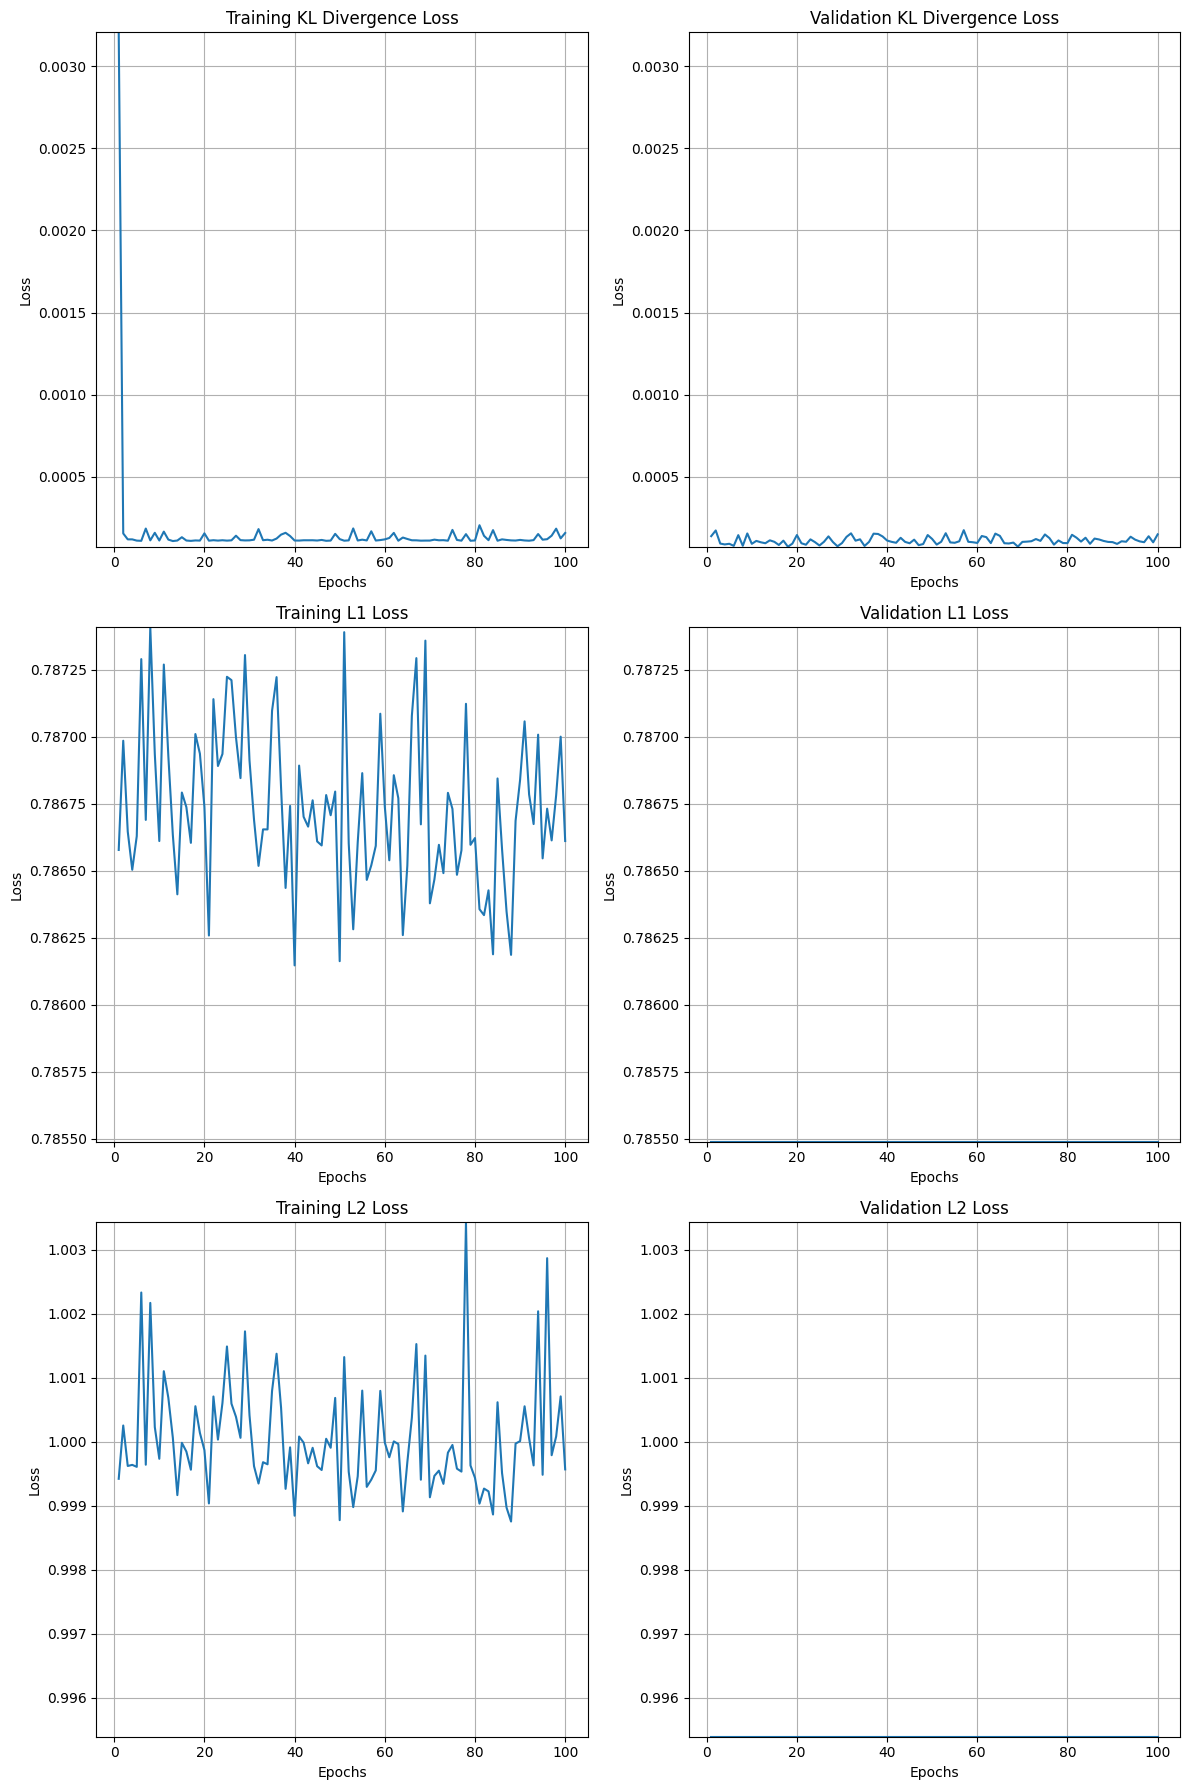

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
75.3523 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


z0: -0.0024
z1: -0.0036
z2: -0.0036
z3: 0.0041


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 678.99it/s]


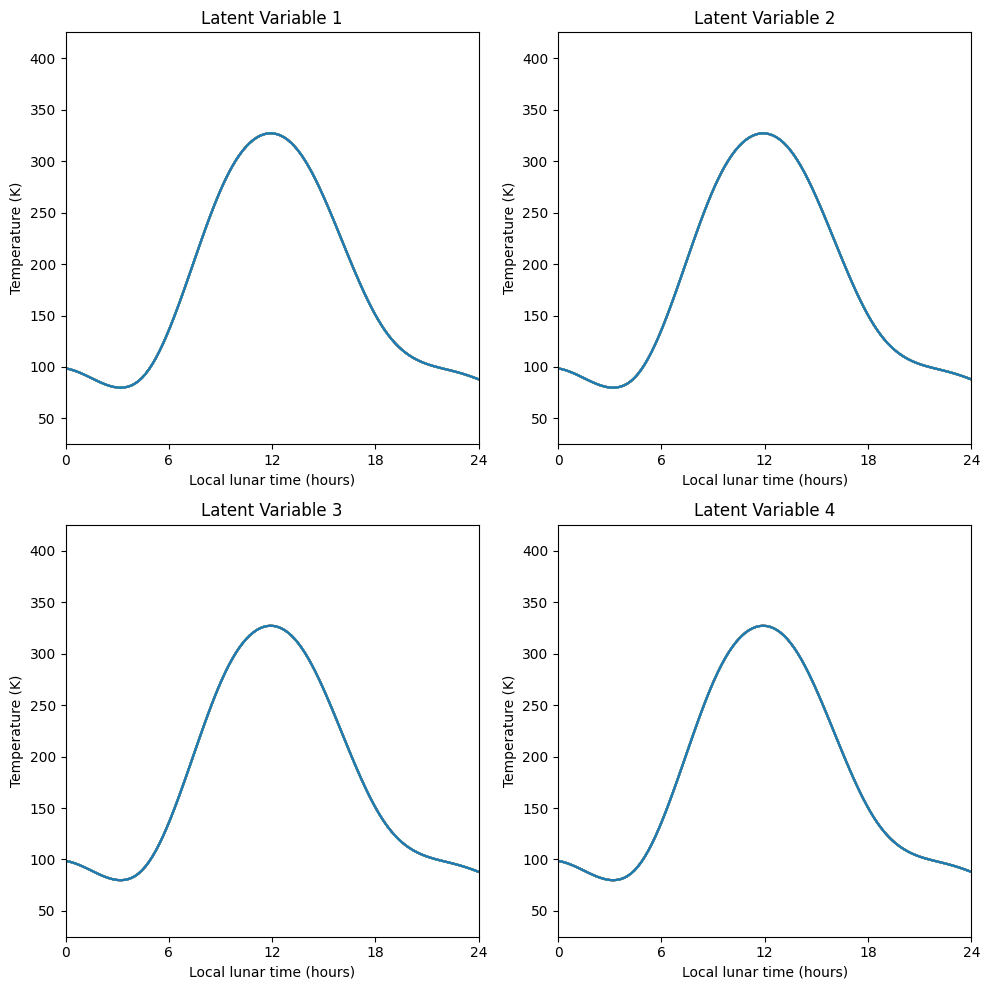

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)